In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 8.0) #視覺圖放大一倍，預設 (8.0,4.0)
plt.rcParams['image.interpolation'] = 'nearest'
import seaborn as sns
sns.set()
import numpy as np
import re
from pandas.core.frame import DataFrame

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
#pd.set_option('display.max_rows', None)
#pd.set_option('max_colwidth',100)

In [3]:
#讀入資料
HomeCDT_train=pd.read_csv("C:/Shared/Final_topic/home-credit-default-risk/application_train.csv")
HomeCDT_previous=pd.read_csv("C:/Shared/Final_topic/home-credit-default-risk/previous_application.csv")
HomeCDT_credit_card_balance=pd.read_csv("C:/Shared/Final_topic/home-credit-default-risk/credit_card_balance.csv")

# HomeCDT_train=pd.read_csv("D:/BigData/machine_learning/2.5G_home-credit-default-risk/application_train.csv")
# HomeCDT_previous=pd.read_csv("D:/BigData/machine_learning/2.5G_home-credit-default-risk/previous_application.csv")

In [34]:
def data_unique(data):
    '''data = 資料集
       計算唯一值個數
    '''
    data = data.apply(lambda x:x.unique().shape[0],axis=0)
    print(data)

def set_col_names(data):
    '''data = 資料集
       建立columns names list
    '''
    global col_names
    col_names = []
    col_names = data.columns

def set_col_type(data):
    '''data = 資料集
       建立columns names 列向量的名稱的list
    '''
    global col_type
    col_type = []
    for i in col_names:
        col_type.append(data[i].values.dtype)

def set_col_type_df(col_names, col_type):
    '''建立colums name的資料框
       colum
    '''
    global col_type_df
    col_Dict={"col_names" : col_names,
              "col_type" : col_type}

    col_type_df=DataFrame(col_Dict)
    
def Create_list(columes_type,col):
    '''columes_type = 列欄位的type 型態要是list
       col_names = 列欄位的names 型態要是list
       將不同資料型態放入各自的list，使用到全域變數，整數、物件、浮點數分類
    '''
    global type_Int64 
    global type_object 
    global type_float64 

    type_Int64 = []
    type_object = []
    type_float64 = []
    
    list_tmp = col_type_df["col_type"]
    list_tmp = list_tmp.values.tolist()
    for i in range(len(col_type)):
        if list_tmp[i] == "int64":
            type_Int64.append(col[i])
        elif list_tmp[i] == "O":
            type_object.append(col[i])
        elif list_tmp[i] == "float64":
            type_float64.append(col[i])
            
def set_train_null(data):
    '''data = 資料集
       挑選出有空值的欄位
       判斷是否有空值
    '''
    global train_null
    count_null = data.isnull().any()
    train_null = data.isnull().sum()[count_null==True]
    
def plot_null_hist(train_null):
    '''train_null = 放入有空值的columns 名稱及個數
    '''
    plt.figure(figsize=(10,10), dpi=70)
    
    train_null[0:9].plot(kind='bar')
    plt.show()
    
def plot_int_hist(data, type_Int64):
    '''data = 資料集
       type_int64 放入type_Int64 型態的columns names
       畫出int類型的直方分布圖
    '''
    for i in range(len(type_Int64)):
        fig,axes = plt.subplots()
        data[type_Int64[i]].plot.hist(bins=50,ax=axes)
        axes.set_title(type_Int64[i])
        
def coefficient(data, type_float64):
    '''data = 資料集
       type_float64 放入type_float64 型態的columns names
       float64 合併目標項並計算相關係數
    '''
    global corDf
    type_float64_df = data[type_float64]

    corDf=type_float64_df.corr()
    print(corDf["TARGET"])
    
def plot_coefficient(data, type_float64):
    '''data = 資料集
       type_float64 放入type_float64 型態的columns names
       畫出相關係數熱圖
    '''
    type_float64_df = data[type_float64]
    type_float64_df["TARGET"] = data["TARGET"]
    plt.figure(figsize=(30, 30))

    g=sns.heatmap(np.abs(corDf), vmin=0., vmax=1., linewidths=0.01,
                square=True,annot=True,cmap='YlGnBu',linecolor="white")
    plt.title('Correlation between features');
    
def plot_pie_chart(type_object, data):
    '''type_object = 放入type_object 型態的columns names
       data = 資料集
       畫圓餅圖,需要有type_object,針對object
    '''
    for j in type_object:
        list_unique = data[j].unique().tolist()
        print("")
        print("")
        print(j)
        for i in range (0,len(list_unique)):
            print ( list_unique[i], ' : ',(list_unique[i] == data[j].values ).sum().tolist() ,sep='' )
            num=[]
        for i in range (0,len(list_unique)):
            num.append((list_unique[i] == data[j].values ).sum().tolist())
            lab=list(zip(list_unique,num))
        plt.pie( num, labels = lab , autopct = '%1.1f%%')
        plt.axis('equal')
        plt.show()
        
def merge_target(data1, data2):
    '''data1 = 原資料(沒有target的),
       data2 = 被合併的資料(有target的)
       將目標項根據 ID 合併到資料中 
       並target裡面有缺失值的 row 都刪除
    '''
    HomeCDT_merge = pd.merge(data1, data2, how='left', on='SK_ID_CURR')
    data1 = pd.concat([data1,HomeCDT_merge['TARGET']],axis=1)

    data1 = data1.dropna(subset=['TARGET'])

In [5]:
#將目標項根據 ID 合併到資料中
#target裡面有缺失值的 row 都刪除
HomeCDT_merge = pd.merge(HomeCDT_credit_card_balance, HomeCDT_train, how='left', on='SK_ID_CURR')
HomeCDT_credit_card_balance = pd.concat([HomeCDT_credit_card_balance,HomeCDT_merge['TARGET']],axis=1)

HomeCDT_credit_card_balance = HomeCDT_credit_card_balance.dropna(subset=['TARGET'])
HomeCDT_credit_card_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,TARGET
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.00,...,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0,1.0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.76,...,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0,0.0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.89,...,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0,0.0


In [8]:
len(HomeCDT_credit_card_balance['SK_ID_PREV'])

3227965

In [10]:
#計算唯一值個數 credit_card_balance
data_unique(HomeCDT_credit_card_balance)

SK_ID_PREV                      87452
SK_ID_CURR                      86905
MONTHS_BALANCE                     96
AMT_BALANCE                   1182278
AMT_CREDIT_LIMIT_ACTUAL           167
AMT_DRAWINGS_ATM_CURRENT         2096
AMT_DRAWINGS_CURRENT           159227
AMT_DRAWINGS_OTHER_CURRENT       1651
AMT_DRAWINGS_POS_CURRENT       143769
AMT_INST_MIN_REGULARITY        278881
AMT_PAYMENT_CURRENT            142262
AMT_PAYMENT_TOTAL_CURRENT      156928
AMT_RECEIVABLE_PRINCIPAL      1045438
AMT_RECIVABLE                 1174197
AMT_TOTAL_RECEIVABLE          1174308
CNT_DRAWINGS_ATM_CURRENT           45
CNT_DRAWINGS_CURRENT              127
CNT_DRAWINGS_OTHER_CURRENT         12
CNT_DRAWINGS_POS_CURRENT          133
CNT_INSTALMENT_MATURE_CUM         122
NAME_CONTRACT_STATUS                7
SK_DPD                            844
SK_DPD_DEF                        308
TARGET                              2
dtype: int64


In [11]:
#建立列欄位名稱的 list
set_col_names(HomeCDT_credit_card_balance)
col_names

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF', 'TARGET'],
      dtype='object')

In [12]:
#建立 type of column list
set_col_type(HomeCDT_credit_card_balance)
col_type

[dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64')]

In [13]:
#合併 col_names 和 col_type 變成 Dataframe
set_col_type_df(col_names, col_type)
col_type_df

,col_names,col_type
0,SK_ID_PREV,int64
1,SK_ID_CURR,int64
2,MONTHS_BALANCE,int64
3,AMT_BALANCE,float64
4,AMT_CREDIT_LIMIT_ACTUAL,int64
5,AMT_DRAWINGS_ATM_CURRENT,float64
6,AMT_DRAWINGS_CURRENT,float64
7,AMT_DRAWINGS_OTHER_CURRENT,float64
8,AMT_DRAWINGS_POS_CURRENT,float64
9,AMT_INST_MIN_REGULARITY,float64


In [14]:
#將不同資料型態放入各自的list，使用到全域變數，應該能有不用到全域變數的方法
#整數、物件、浮點數分類
Create_list(col_type,col_names)
type_Int64
# type_float64
# type_object

['SK_ID_PREV',
 'SK_ID_CURR',
 'MONTHS_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'CNT_DRAWINGS_CURRENT',
 'SK_DPD',
 'SK_DPD_DEF']

In [15]:
#挑選出有空值的欄位
#判斷是否有空值
set_train_null(HomeCDT_credit_card_balance)
train_null

AMT_DRAWINGS_ATM_CURRENT      605754
AMT_DRAWINGS_OTHER_CURRENT    605754
AMT_DRAWINGS_POS_CURRENT      605754
AMT_INST_MIN_REGULARITY       264384
AMT_PAYMENT_CURRENT           620093
CNT_DRAWINGS_ATM_CURRENT      605754
CNT_DRAWINGS_OTHER_CURRENT    605754
CNT_DRAWINGS_POS_CURRENT      605754
CNT_INSTALMENT_MATURE_CUM     264384
dtype: int64

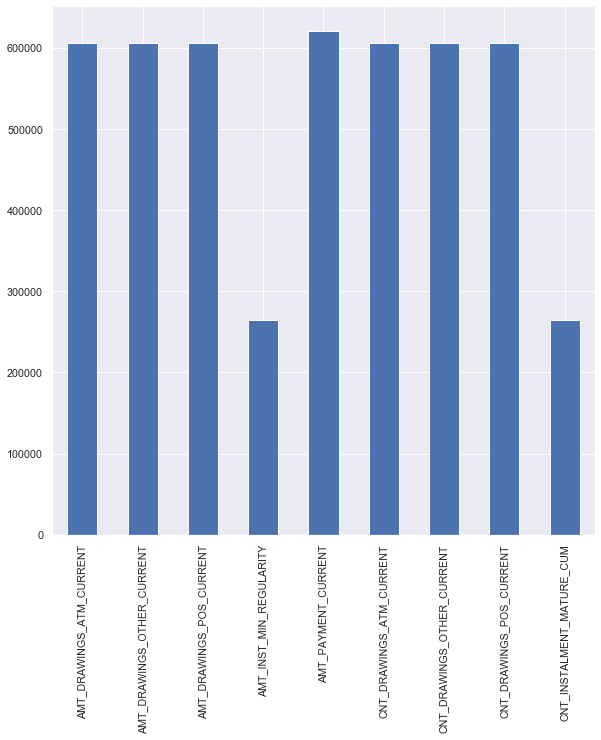

In [35]:
plot_null_hist(train_null)

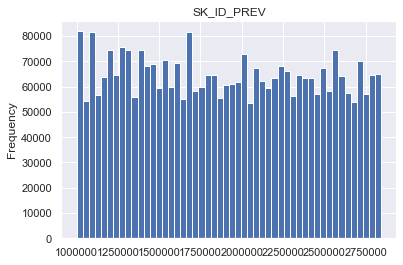

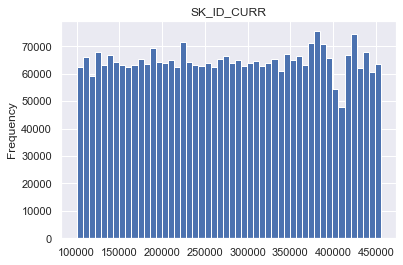

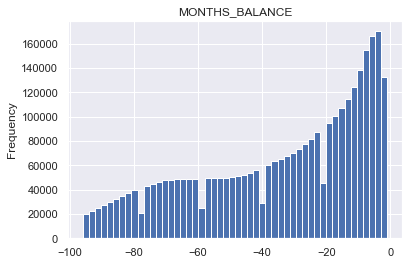

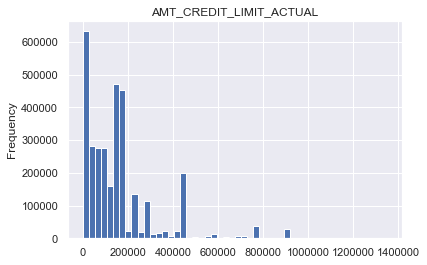

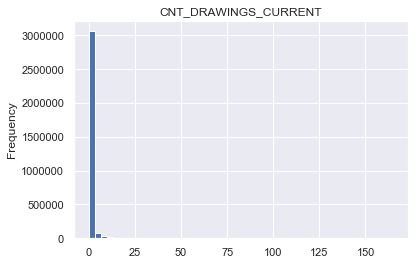

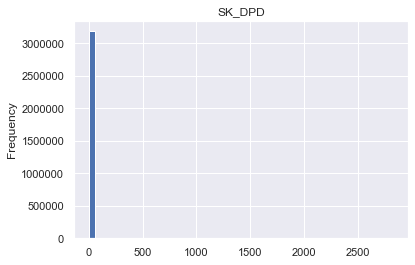

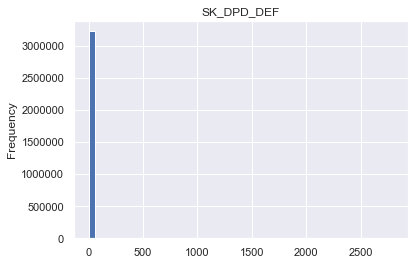

In [17]:
#數值型看分佈圖
plot_int_hist(HomeCDT_credit_card_balance, type_Int64)

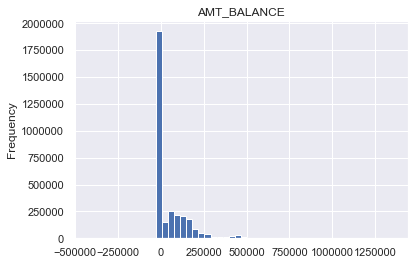

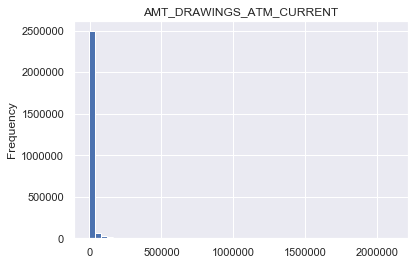

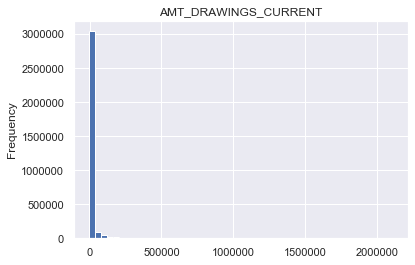

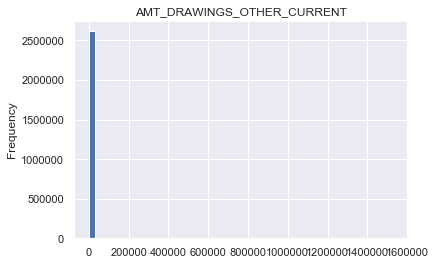

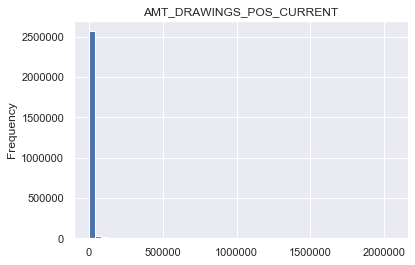

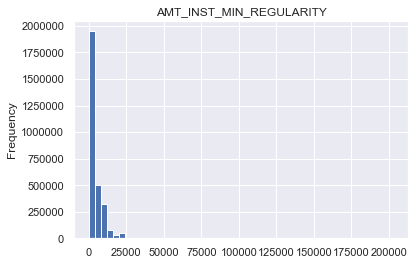

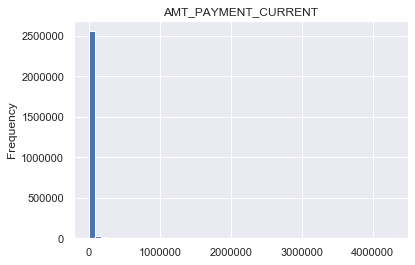

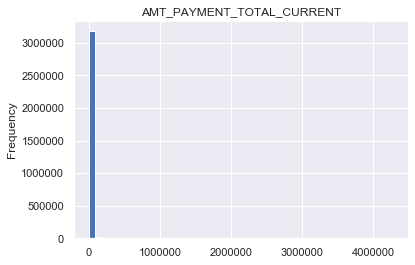

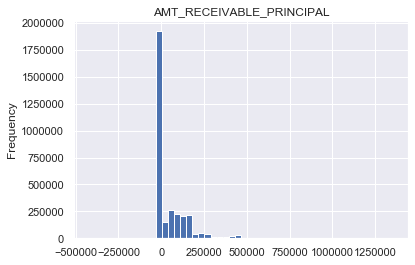

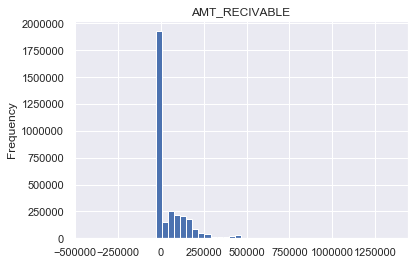

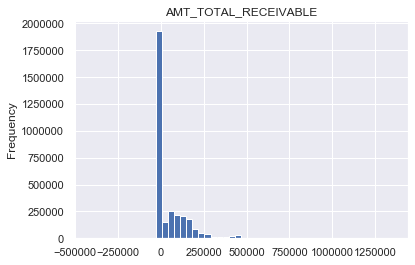

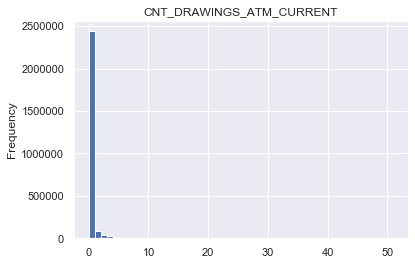

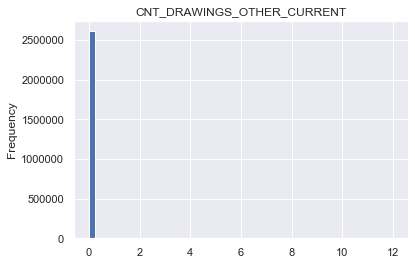

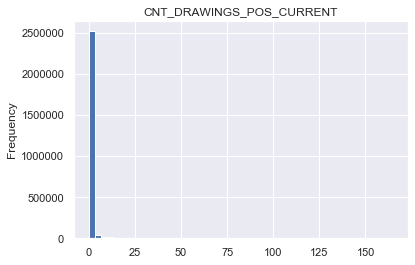

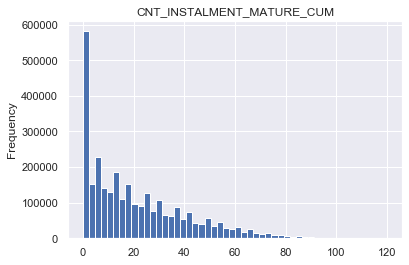

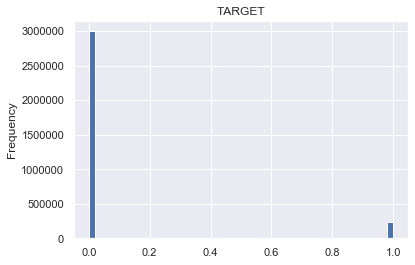

In [19]:
plot_int_hist(HomeCDT_credit_card_balance, type_float64)

In [15]:
#針對 float64 建立 Dataframe 合併目標項
#計算相關係數 
coefficient(HomeCDT_credit_card_balance, type_float64)

AMT_BALANCE                   0.050098
AMT_DRAWINGS_ATM_CURRENT      0.024700
AMT_DRAWINGS_CURRENT          0.022378
AMT_DRAWINGS_OTHER_CURRENT    0.003843
AMT_DRAWINGS_POS_CURRENT      0.005084
AMT_INST_MIN_REGULARITY       0.039798
AMT_PAYMENT_CURRENT           0.012929
AMT_PAYMENT_TOTAL_CURRENT     0.012302
AMT_RECEIVABLE_PRINCIPAL      0.049692
AMT_RECIVABLE                 0.049803
AMT_TOTAL_RECEIVABLE          0.049839
CNT_DRAWINGS_ATM_CURRENT      0.038437
CNT_DRAWINGS_OTHER_CURRENT    0.003044
CNT_DRAWINGS_POS_CURRENT      0.029536
CNT_INSTALMENT_MATURE_CUM    -0.023684
TARGET                        1.000000
Name: TARGET, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


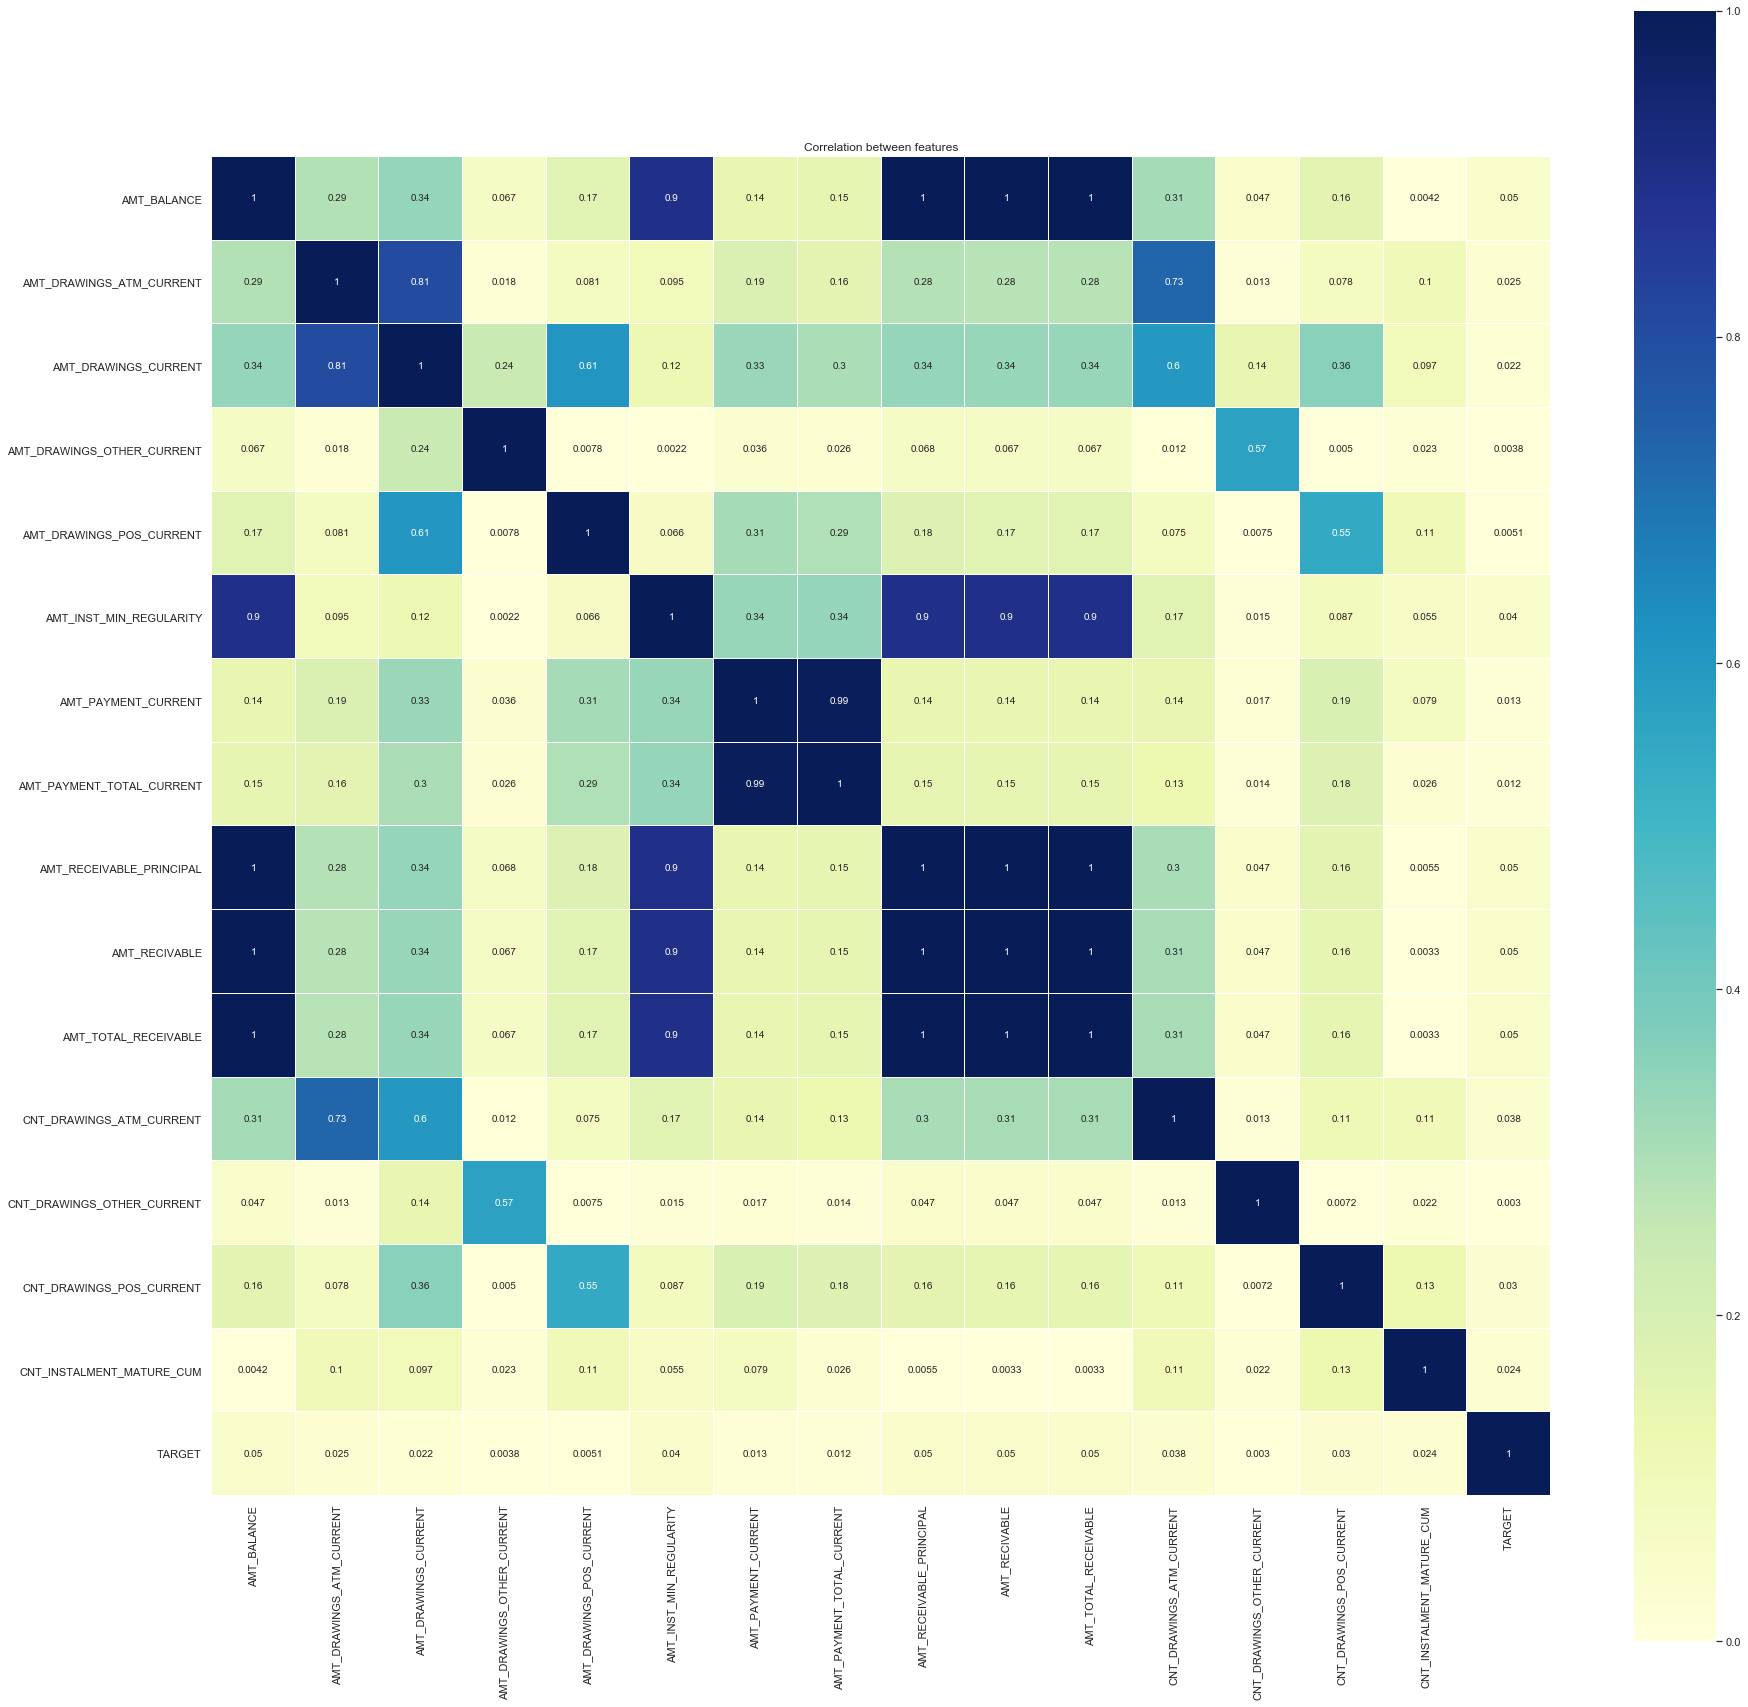

In [16]:
#畫其他和 target 相關係數熱圖
plot_coefficient(HomeCDT_credit_card_balance, type_float64)



NAME_CONTRACT_STATUS
Active : 3116673
Completed : 100031
Signed : 9939
Demand : 843
Sent proposal : 460
Refused : 14
Approved : 5


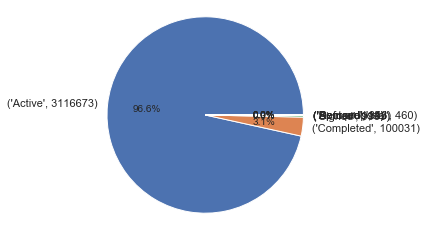

In [17]:
# object 看各個 object 資料的分布 的圓餅圖
plot_pie_chart(type_object, HomeCDT_credit_card_balance)